<a href="https://colab.research.google.com/github/feelthevenom/Plant_Disease_Segmentation/blob/main/Plant_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Todo:

## Augmentation
## Model Architecture
## Hyperparameter tuning
## Evaluate

In [ ]:
!pip install segmentation-models-pytorch

In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dirr = '/content/drive/MyDrive/orig_data'
train_images = dirr + '/train_images'
train_masks = dirr + '/train_masks'
valid_images = dirr + '/valid_images'
valid_masks = dirr + '/valid_masks'

classes = ['background','affected']

In [28]:
# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [36]:
# Custom Dataset
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_names, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = image_names
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        # Convert mask to binary (0 and 1)
        mask = (mask > 0).float()

        return image, mask

In [40]:
def visualize_dataset_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]

        # Convert image tensor to numpy array and denormalize
        image_np = image.numpy().transpose(1, 2, 0)
        image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

        # Convert mask tensor to numpy array and squeeze the single channel dimension
        mask_np = mask.numpy().squeeze() # Squeeze the single channel dimension

        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title(f"Image {i+1}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(mask_np, cmap='gray')
        axs[i, 1].set_title(f"Mask {i+1} (White: {np.sum(mask_np) / mask_np.size * 100:.2f}%)")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [37]:
# Data splitting and loading
image_names = [f for f in os.listdir(train_images) if f.endswith('.jpg')]
train_names, test_names = train_test_split(image_names, test_size=0.1, random_state=42)

train_dataset = PlantDiseaseDataset(train_images, train_masks, train_names, transform=image_transform, target_transform=mask_transform)
test_dataset = PlantDiseaseDataset(train_images, train_masks, test_names, transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Visualizing training samples:


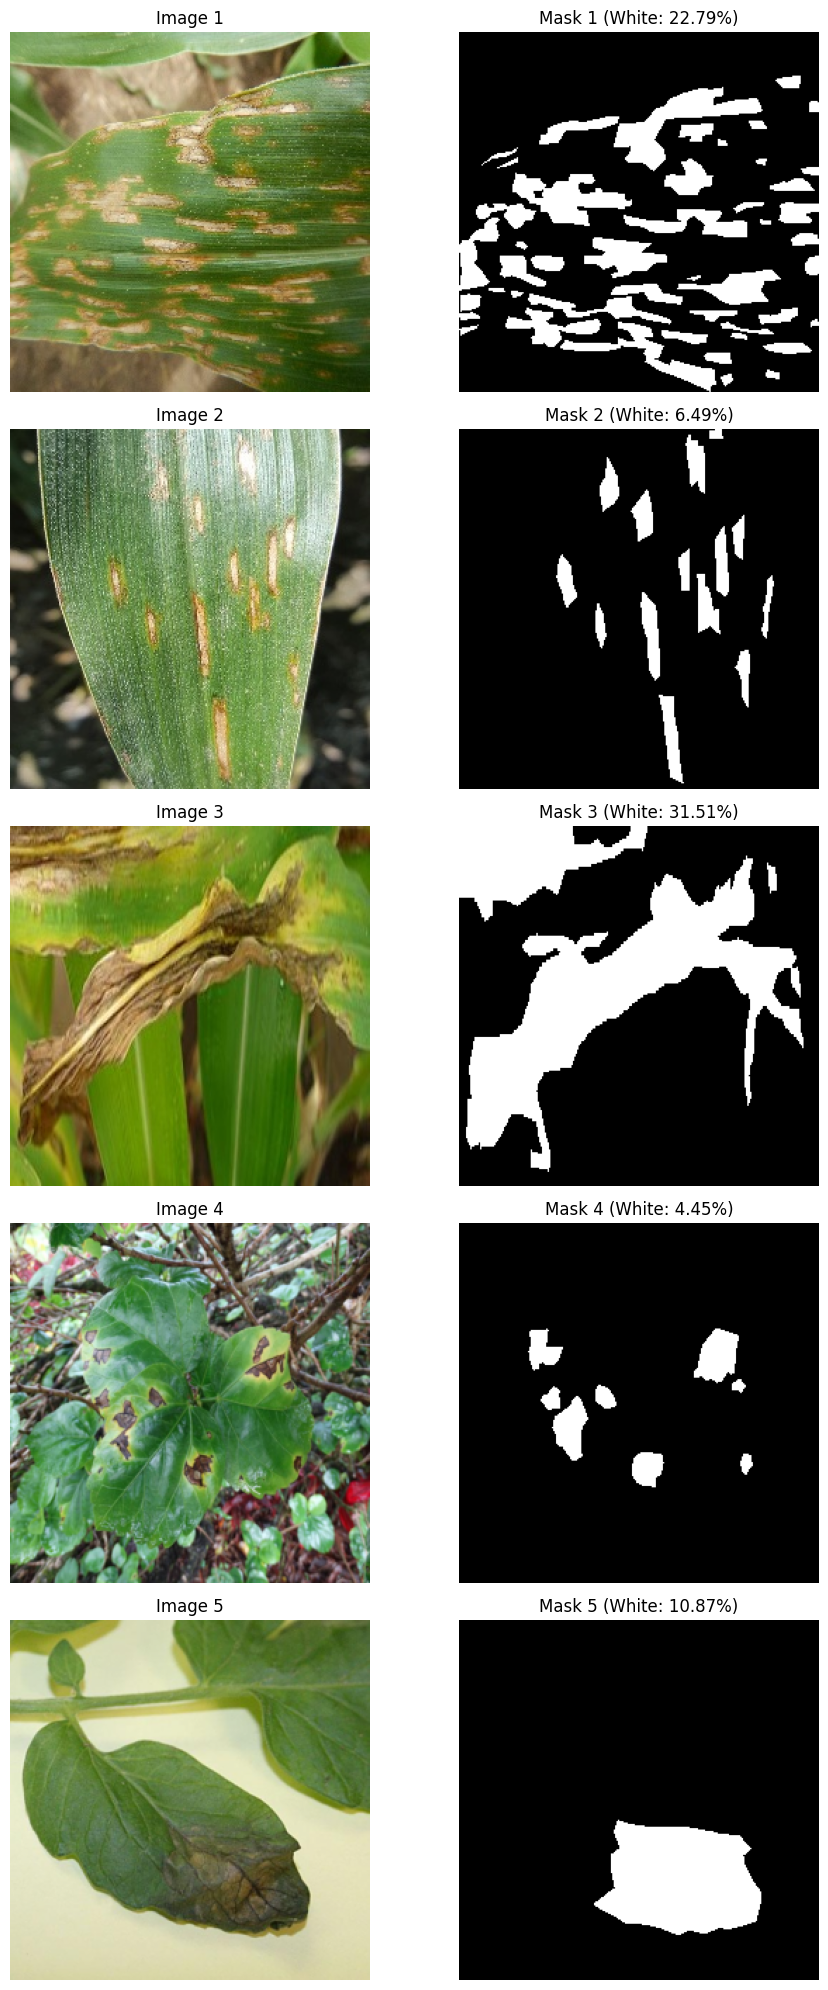

In [41]:
# Visualize some samples from the training dataset
print("Visualizing training samples:")
visualize_dataset_samples(train_dataset)

In [49]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(classes),
    activation='sigmoid',
)


In [42]:
criterion = smp.losses.DiceLoss(mode='multiclass')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
# Training function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Ensure targets are class indices (LongTensor)
        targets = targets.long()  # Convert targets to LongTensor if they are not
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Ensure targets are class indices (LongTensor)
            targets = targets.long()  # Convert targets to LongTensor if they are not
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(loader)

In [46]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
writer = SummaryWriter(f'runs/plant_disease_segmentation_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)

writer.close()

# Save the model
torch.save(model.state_dict(), 'plant_disease_segmentation_model.pth')

Epoch 1/10, Train Loss: 0.4816, Val Loss: 0.4693
Epoch 2/10, Train Loss: 0.4433, Val Loss: 0.4247
Epoch 3/10, Train Loss: 0.4349, Val Loss: 0.4282
Epoch 4/10, Train Loss: 0.4286, Val Loss: 0.4190
Epoch 5/10, Train Loss: 0.4257, Val Loss: 0.4258
Epoch 6/10, Train Loss: 0.4302, Val Loss: 0.4304
Epoch 7/10, Train Loss: 0.4312, Val Loss: 0.4198
Epoch 8/10, Train Loss: 0.4257, Val Loss: 0.4218
Epoch 9/10, Train Loss: 0.4255, Val Loss: 0.4178
Epoch 10/10, Train Loss: 0.4200, Val Loss: 0.4197


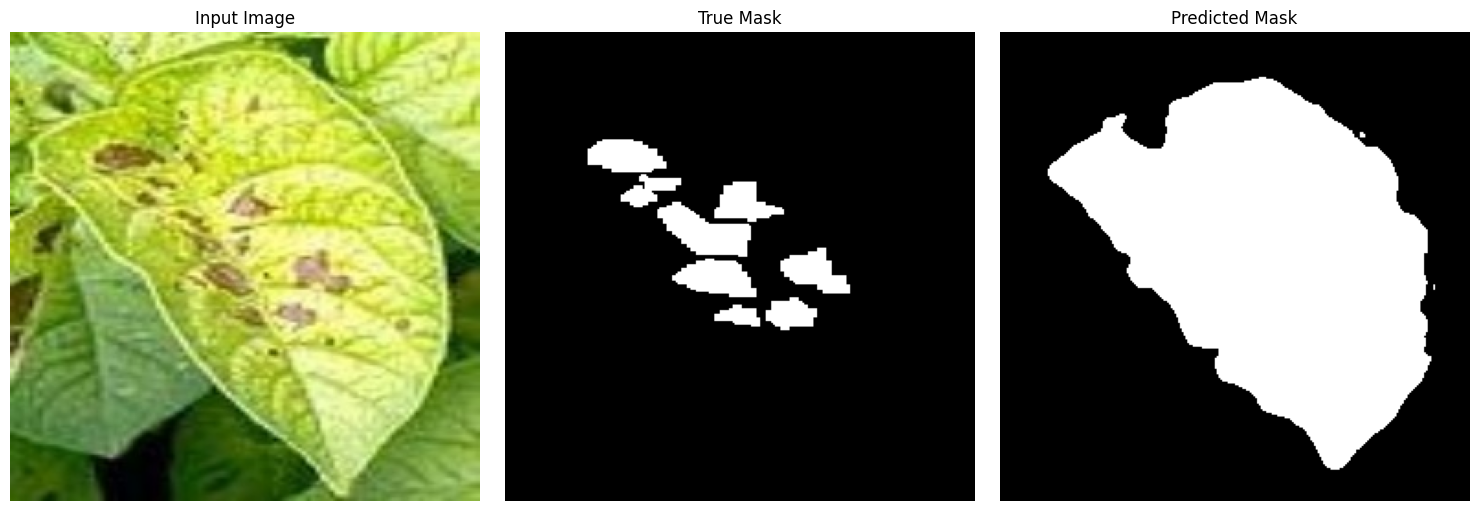

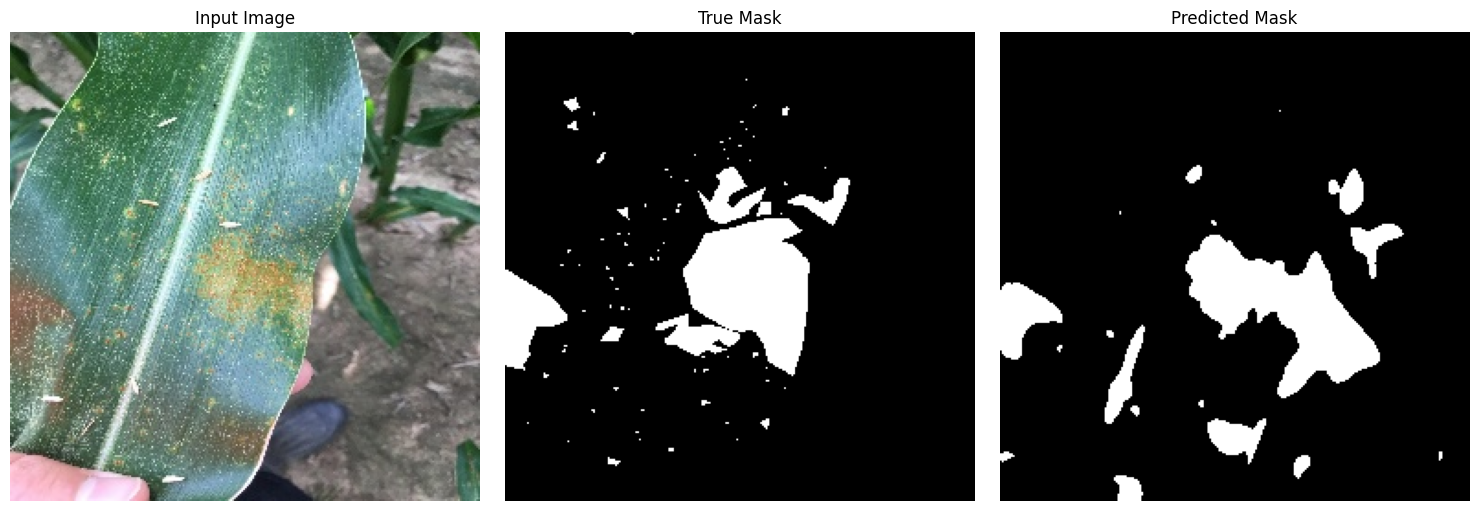

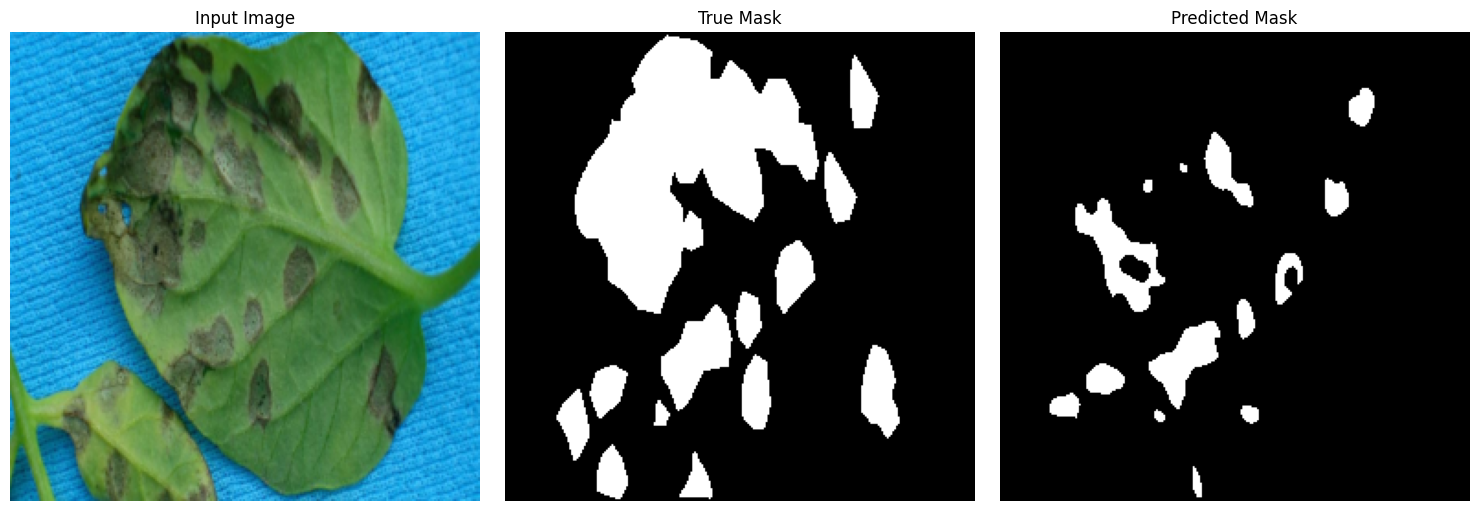

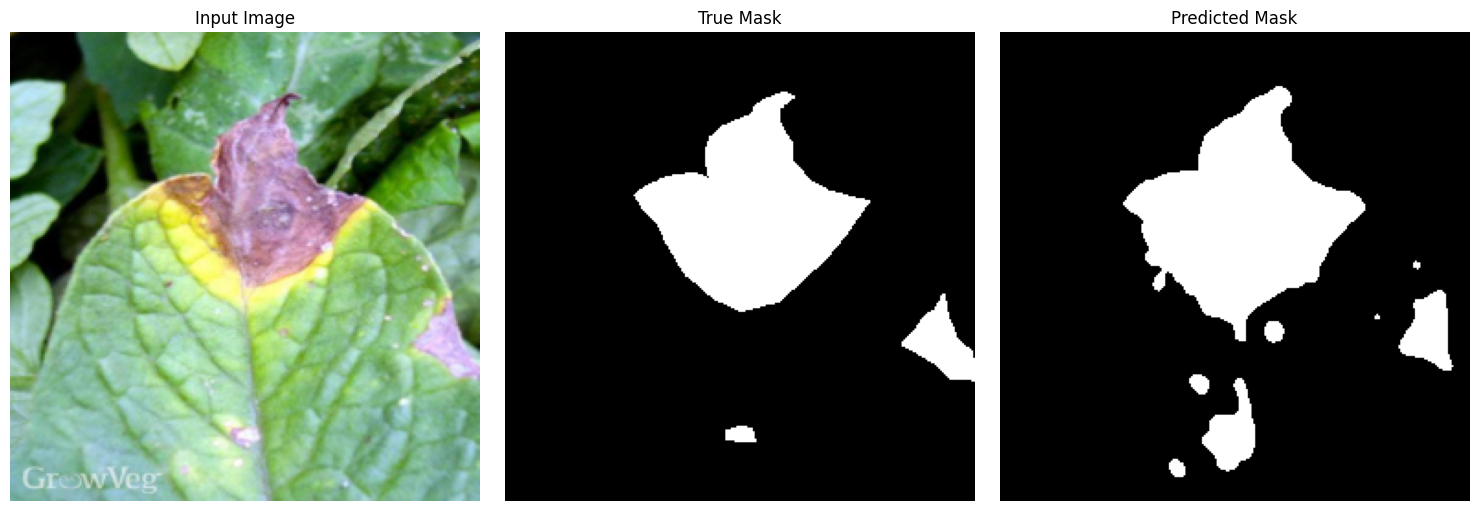

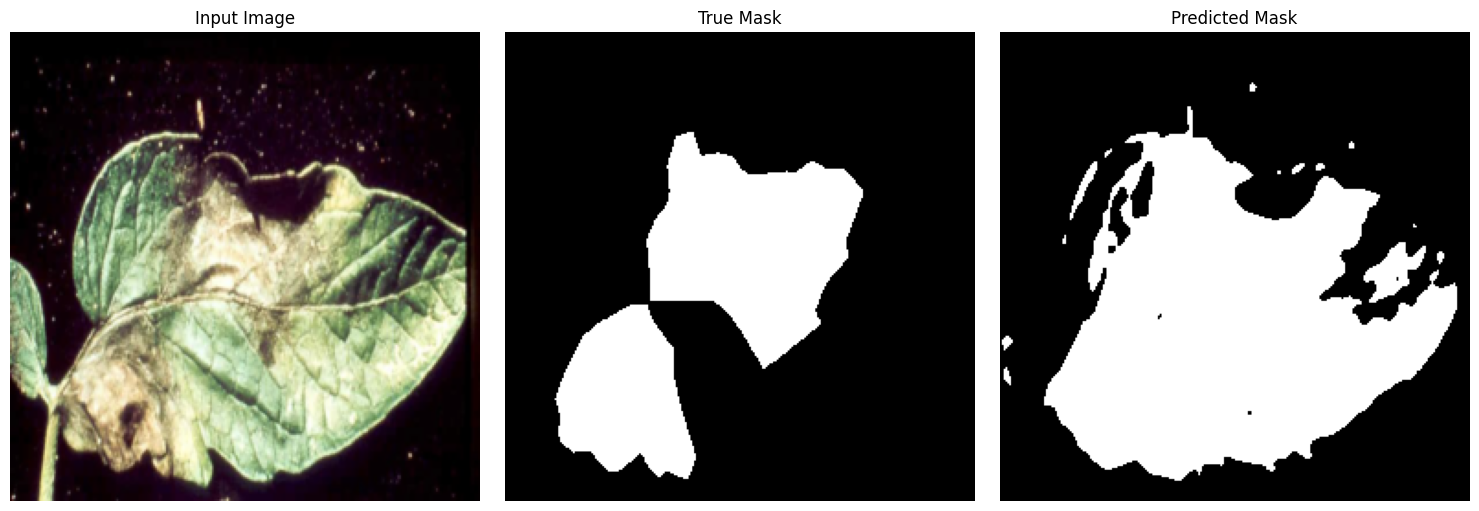

In [48]:
# Testing and visualization function
def test_and_visualize(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_images:
                break

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)

            # Convert tensors to numpy arrays
            input_image = inputs[0].cpu().permute(1, 2, 0).numpy()
            true_mask = targets[0].cpu().numpy()
            pred_mask = predicted[0].cpu().numpy()

            # Denormalize the input image
            input_image = (input_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

            # Plotting
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(input_image)
            axs[0].set_title('Input Image')
            axs[0].axis('off')

            # Squeeze the true_mask to remove the single channel dimension
            axs[1].imshow(true_mask.squeeze(), cmap='gray')  # Squeeze to 2D
            axs[1].set_title('True Mask')
            axs[1].axis('off')

            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title('Predicted Mask')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

# Test and visualize results
test_and_visualize(model, test_loader, device)